# Computer Vision Project

### Setup

In [117]:
import os                           # type: ignore
import numpy as np                  # type: ignore
import matplotlib.pyplot as plt     # type: ignore
import pandas as pd                 # type: ignore
import albumentations as albu       # type: ignore
import importlib
import segmentation
import segmentation.dataset
importlib.reload(segmentation.dataset)

from segmentation.dataset import CVDataset
importlib.reload(segmentation.dataset)
from segmentation.utils import preprocessing, show, model_utils, ModelEval


from models import unet_model

In [118]:
importlib.reload(segmentation.utils)

<module 'segmentation.utils' from '/Users/georgeboutselis/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Year 4/Semester 2/Computer Vision/Computer-Vision-Project/segmentation/utils.py'>

In [119]:
# Defining some constants that will be used throughout the notebook
CLASSES = ['dog', 'cat', 'background']
DATA_DIR = 'Dataset/'
x_test_dir = os.path.join(DATA_DIR, 'Test/color')
y_test_dir = os.path.join(DATA_DIR, 'Test/label')
x_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/color')
y_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/label')

### Splitting the TrainVal data into training and validation data
* Splitting into training and validations sets is needed so we can evaluate peformance on the model while training.
* More common than K-fold cross validation in deep learning settings because of computational costs.

In [120]:
# Getting a list of relative paths to the images (x) and the masks/labels (y)
x_test_fps, y_test_fps = preprocessing.get_testing_paths(x_test_dir, y_test_dir)

# Splitting relative path names into into training and validation
x_train_fps, x_val_fps, y_train_fps, y_val_fps = preprocessing.train_val_split(x_trainVal_dir, y_trainVal_dir, 0.2)


### Custom Dataset

In [121]:
test_augmentation = preprocessing.get_validation_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()

train_dataset = CVDataset(x_train_fps, y_train_fps)
valid_dataset = CVDataset(x_val_fps, y_val_fps)

test_dataset  = CVDataset(
                x_test_fps,
                y_test_fps,
                augmentation = test_augmentation,
                preprocessing=preprocessing_fn
                )


# Printing the size of each dataset
print(f'Training dataset has size {train_dataset.__len__()}')
print(f'Validation dataset has size {valid_dataset.__len__()}')
print(f'Testing dataset has size {test_dataset.__len__()}')

Training dataset has size 2938
Validation dataset has size 735
Testing dataset has size 3694


In [122]:
model = unet_model.UNET(in_channels=3, out_channels=3)

In [123]:
eval = ModelEval(test_dataset, model, device = 'cpu')

In [ ]:
eval.load_model('s3://computer-vision-state-dictionaries/unet_experiment_1/unet_best_model_trial_0.pth')

In [ ]:
eval.mean_IoU(progress_bar=True)

100%|██████████| 3694/3694 [20:27<00:00,  3.01it/s]


0.7758989930152893

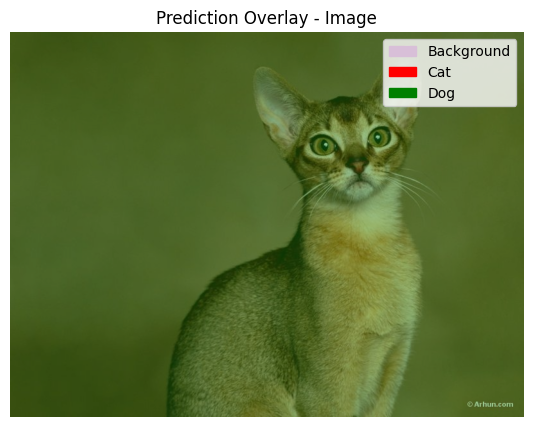

In [35]:
eval.plot_prediction_overlay(26, alpha=0.4)

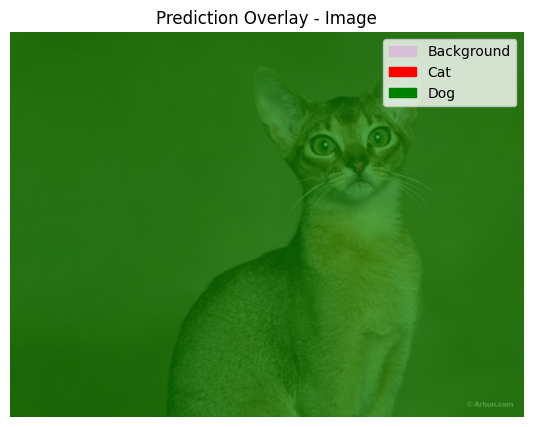

IoU on original domain: 0.0000


In [36]:
eval.image_fit_summary(26, alpha = 0.7)

## Point based segmentation

In [125]:
import segmentation.dataset
importlib.reload(segmentation.dataset)
from segmentation.dataset import CVDataset
import segmentation.utils
importlib.reload(segmentation.utils)
from segmentation.utils import show

In [126]:
train_aumentation = preprocessing.get_training_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()
train_dataset = CVDataset(x_train_fps, y_train_fps, augmentation=train_aumentation)

In [127]:
image, mask = train_dataset[5]
image.shape

(256, 416, 3)

In [ ]:
from torch.utils.data import Dataset as BaseDataset
from segmentation.constants import DataSetConstants
import cv2
from segmentation.utils import preprocessing

class PointDataset(CVDataset):
    def __init__(self, images_fps, masks_fps, prompt_points = None, augmentation = None, preprocessing = None):
        super().__init__(images_fps, masks_fps, augmentation, preprocessing)
        self.prompt_points = prompt_points

        # Checking enough prompt points were provided
        if (prompt_points) and (self.__len__() != len(prompt_points)):
            ValueError(f'{len(prompt_points)} provided however exactly {self.__len__()} required')

    def __getitem__(self, i):
        image = self.original_image(i)
        mask = self.original_mask(i)
        prompt_point = (150, 100)  # (x, y) coordinates

        if self.augmentation:
            # Apply the augmentation while passing the prompt point as a keypoint.
            sample = self.augmentation(image=image, mask=mask, keypoints=[prompt_point])
            image, mask, keypoint = sample['image'], sample['mask'], sample['keypoints']
            # Checking if our keypoint is still there after augmentation (otherwise put it in the center)
            if len(keypoint) == 0:
                # Shape of mask image is HWC
                x_centre, y_centre = image.shape[0]//2, image.shape[1]//2
                keypoint = [[x_centre, y_centre]]

            # keypoint nested list [[x, y]] to tuple (x, y)
            prompt_point = tuple(keypoint[0])
            
        # Getting the heatmap for the key point & image dimensions (still before preprocessing so numpy)
        heatmap_shape = mask.shape
        heatmap = preprocessing.create_heatmap(heatmap_shape, prompt_point, sigma=10)


        return image, mask, heatmap

        

In [213]:
train_dataset = PointDataset(x_train_fps, y_train_fps, augmentation=train_aumentation, preprocessing=preprocessing_fn)
image, mask, heatmap = train_dataset[1]


In [214]:
keypoint

array([[6.06309920e-173, 9.72437865e-172, 1.54413797e-170, ...,
        1.06581961e-044, 2.74925285e-045, 7.02106052e-046],
       [9.46140685e-173, 1.51747975e-171, 2.40961217e-170, ...,
        1.66320105e-044, 4.29018212e-045, 1.09562961e-045],
       [1.46175241e-172, 2.34445016e-171, 3.72276179e-170, ...,
        2.56958419e-044, 6.62817289e-045, 1.69270727e-045],
       ...,
       [1.71137025e-262, 2.74480291e-261, 4.35848351e-260, ...,
        3.00838221e-134, 7.76004051e-135, 1.98176439e-135],
       [2.12735507e-263, 3.41198545e-262, 5.41790534e-261, ...,
        3.73963328e-135, 9.64628288e-136, 2.46347424e-136],
       [2.61814107e-264, 4.19913880e-263, 6.66782930e-262, ...,
        4.60237579e-136, 1.18717038e-136, 3.03180375e-137]])

In [205]:
len([[1, 2]])

1

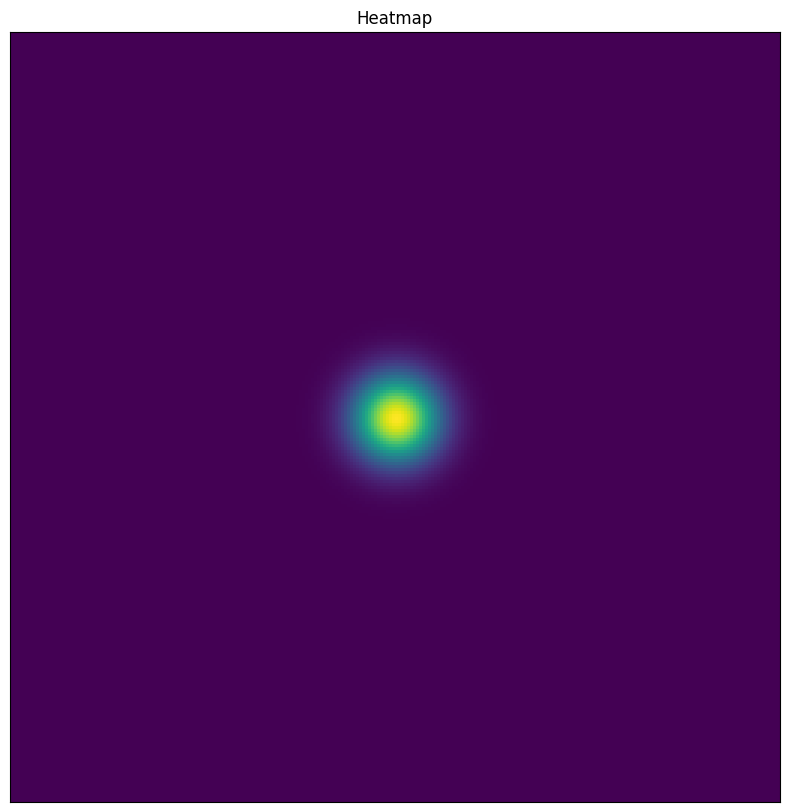

In [ ]:


k


# Example usage:
image_shape = (256, 256)
prompt_point = (128, 128)  # (x, y)
sigma_value = 15

show.visualiseData(heatmap = create_heatmap(image_shape, prompt_point, 10))

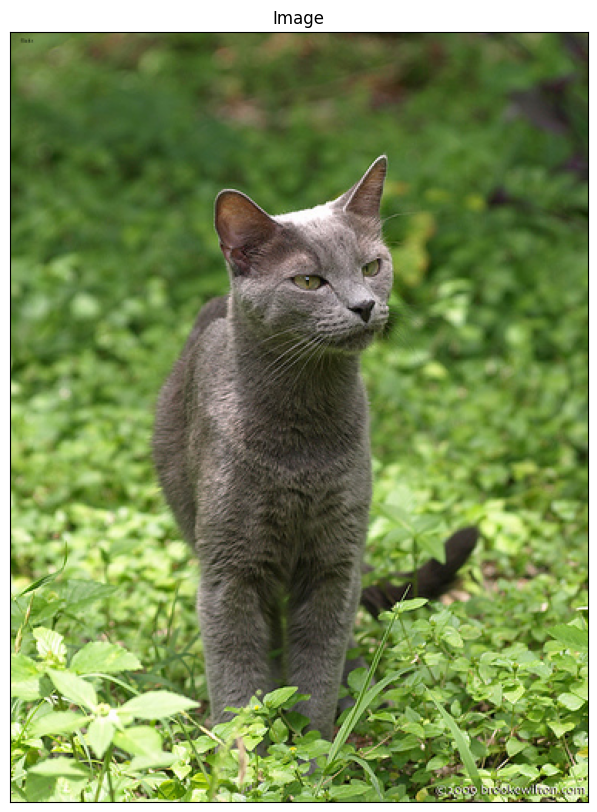

In [22]:
show.visualiseData(image=image)